In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

**Loading images**

In [28]:
new_base_dir = Path("cats_vs_dogs_small")

In [29]:
train_dataset = image_dataset_from_directory(new_base_dir / "train", image_size=(180, 180), batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir / "validation", image_size=(180, 180), batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / "test", image_size=(180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


**Instantiating the VGG16 convolutional base**

In [30]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(180, 180, 3))

In [31]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [32]:
def get_features_and_labels(dataset):
    
    all_features = []
    all_labels = []
    
    for image, label in dataset:

        preprocessed_images = preprocess_input(image)
        features = vgg16.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(label)
    
    return np.concatenate(all_features), np.concatenate(all_labels)

In [33]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 15ms/step


**Classifier Design**

In [34]:
inputs = Input(shape=(5, 5, 512))

x = Flatten()(inputs)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs, outputs)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [35]:
callbacks = [ModelCheckpoint(filepath="feature_extraction.keras", save_best_only=True, monitor="val_loss")]
history = model.fit(train_features, train_labels, epochs=20, 
                    validation_data=(val_features, val_labels), callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 9ms/step - loss: 16.1035 - accuracy: 0.9235 - val_loss: 5.0021 - val_accuracy: 0.9670
Epoch 2/20
63/63 [==============================] - 0s 4ms/step - loss: 1.7419 - accuracy: 0.9840 - val_loss: 11.4089 - val_accuracy: 0.9420
Epoch 3/20
63/63 [==============================] - 0s 3ms/step - loss: 2.2685 - accuracy: 0.9855 - val_loss: 10.1546 - val_accuracy: 0.9430
Epoch 4/20
63/63 [==============================] - 0s 4ms/step - loss: 2.4720 - accuracy: 0.9840 - val_loss: 6.7440 - val_accuracy: 0.9630
Epoch 5/20
63/63 [==============================] - 0s 4ms/step - loss: 0.7520 - accuracy: 0.9960 - val_loss: 4.9746 - val_accuracy: 0.9750
Epoch 6/20
63/63 [==============================] - 0s 4ms/step - loss: 0.8987 - accuracy: 0.9935 - val_loss: 3.7623 - val_accuracy: 0.9770
Epoch 7/20
63/63 [==============================] - 0s 4ms/step - loss: 0.4128 - accuracy: 0.9955 - val_loss: 4.7277 - val_accuracy: 0.9780
Epoch 8/20
63/63 

**Plotting the results**

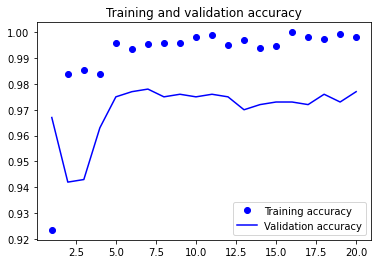

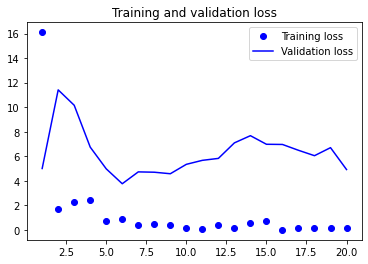

In [36]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()